In [1]:
# Quick notebook to train and save a model (either FGN or classic)
# Part 1 train the network
# part 2 evaluate over random noise
# used to explore hyper params

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib as mpl
# set this 'backend' when using jupyter; do this before importing pyplot
mpl.use('nbagg')
import matplotlib.pyplot as plt

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import numpy as np
from scipy import stats

import sys
sys.path.append('/home/felix/Research/Adversarial Research/FGN---Research/')
import Finite_Gaussian_Network_lib as fgnl
import Finite_Gaussian_Network_lib.fgn_helper_lib as fgnh

In [5]:
!gpustat

countdown               Fri Jul 10 12:23:19 2020  418.87.01
[0] GeForce RTX 2080 Ti | 44'C,   0 % |    11 / 10989 MB |
[1] GeForce RTX 2080 Ti | 45'C,   0 % |  5378 / 10988 MB | felix(5197M) root(169M)


In [6]:
# Define what device we are using

# manualy set cuda device
torch.cuda.set_device(1)

print("CUDA Available: ",torch.cuda.is_available())
use_cuda = True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
print("Using device:", device)


CUDA Available:  True
Using device: cuda


In [7]:
# # random seeds
# torch.manual_seed(999)
# np.random.seed(999)

# torch.backends.cudnn.deterministic = True
# torch.cuda.manual_seed_all(999)

In [8]:
# load MNIST data
batch_size = 4000
(mnist_train_loader, mnist_val_loader, mnist_test_loader) = fgnh.mnist_dataloaders(batch_size=batch_size
                                                                                   ,batch_size_for_val=10000)
# minimum/maximum pixel value post normalization, from train dataset
min_pix = -0.4242129623889923095703125
max_pix =  2.8214867115020751953125000
# mean and std of train set
train_mean = -0.0000061691193877777550369501113891601562500000000
train_std = 0.999999344348907470703125000000

Shape: torch.Size([50000, 28, 28])
type: <class 'numpy.ndarray'>
shape: torch.Size([28, 28])
Label: 5
type: <class 'torch.Tensor'>


<IPython.core.display.Javascript object>


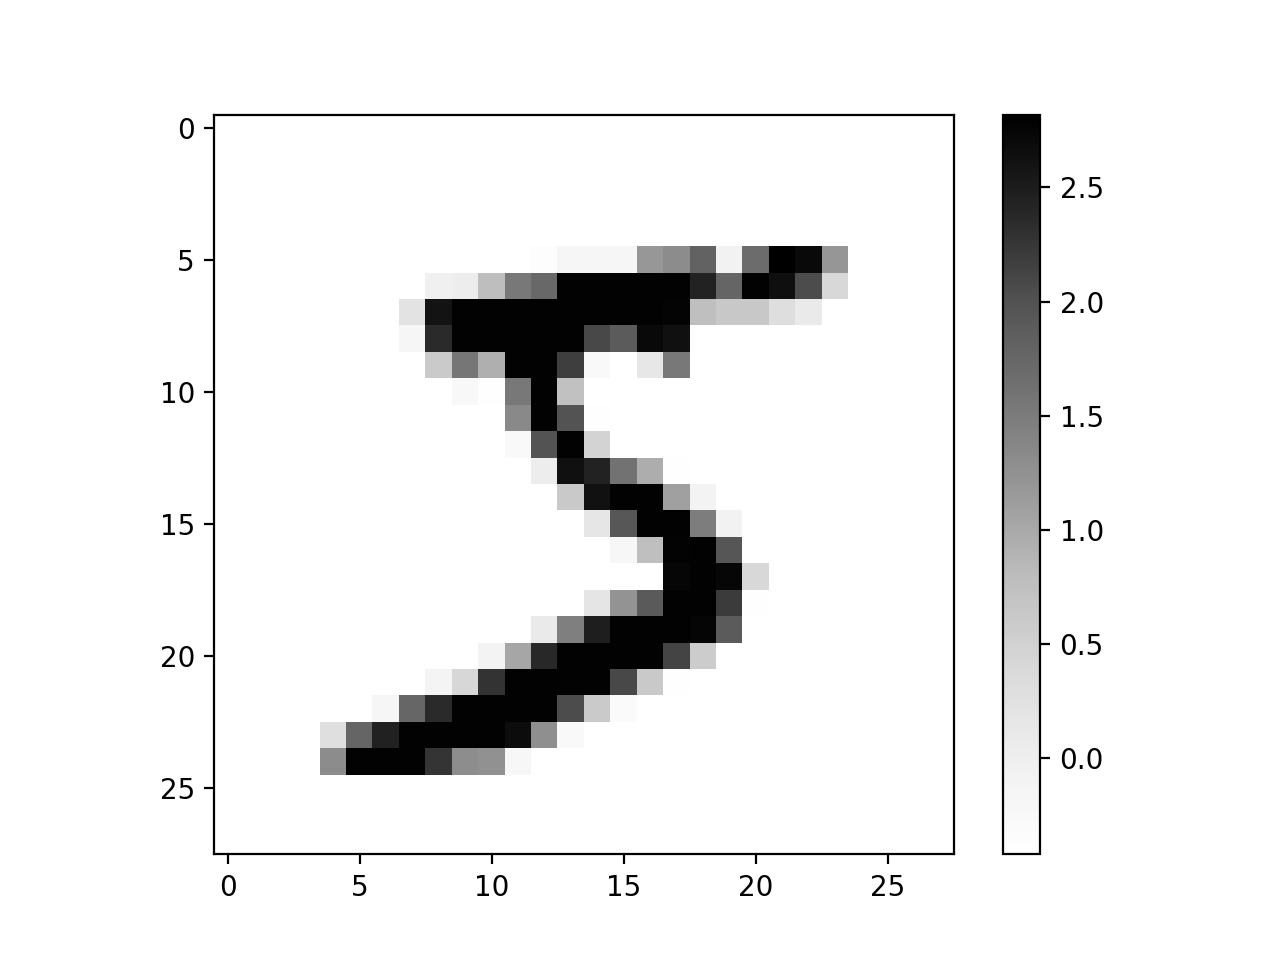

In [9]:
# show an example
print("Shape:", mnist_train_loader.dataset.tensors[0].shape)
x = mnist_train_loader.dataset.tensors[0][0]
print("type:", type(x.numpy()))
print("shape:", x.shape)
# print("sample:", x.numpy())

y = mnist_train_loader.dataset.tensors[1][0]
print("Label:",y.numpy())
print("type:", type(y))

plt.imshow(x, cmap=plt.cm.get_cmap('Greys'))
plt.colorbar()
plt.show()

In [10]:
# PART 1: define and train a network

In [11]:
### loss functions for the classic net
lmbda_l2 = (4.0*0.1/len(mnist_train_loader.dataset))

### Loss Functions for the FGN
# importances of the constraints
lmbda_l2 = (4.0*0.1/len(mnist_train_loader.dataset))
lmbda_sigs = 0.01
# sig_params = sum(p.numel() for n,p in fgn_model.named_parameters() if 'sigs' in n)
# lmbda_sigs = (1.0/sig_params)

# lmbda_l2 = 0.0
# lmbda_sigs = 0.0
print("lambda for l2 loss", lmbda_l2)
print("lambda for sigs^2 loss", lmbda_sigs)

lambda for l2 loss 8e-06
lambda for sigs^2 loss 0.01


In [12]:
# shared network parameters
hidden_layer_sizes = [64,64]
drop_p = 0.2

In [13]:
# fgn specific params
print("hidden layers:", hidden_layer_sizes)
# covariance type: sphere, diag or full/chol
covar_type = 'sphere'
print("covariance:", covar_type)
ordinal = float(2.0)
print("ordinal for norm:", ordinal)
non_lin = True
print("non linearity:", non_lin)
free_biases = True
print("free biases:", free_biases)

print("drop prob:", drop_p)

hidden layers: [64, 64]
covariance: sphere
ordinal for norm: 2.0
non linearity: True
free biases: True
drop prob: 0.2


In [14]:
model_type = 'FGN'
if model_type=='classic':
    # classic model init
    model = fgnl.Feedforward_Classic_net(in_feats=28*28, out_feats=10, hidden_layer_sizes=hidden_layer_sizes, drop_p=drop_p)
    cross_ent_loss = fgnh.def_classical_cross_ent_loss(lmbda_l2)
    
if model_type=='FGN':
    # FGN model init
    model = fgnl.Feedforward_FGN_net(in_feats=28*28, out_feats=10, hidden_layer_sizes=hidden_layer_sizes, drop_p=drop_p,
                                     covar_type=covar_type, ordinal=ordinal, non_lin=non_lin, free_biases=free_biases)
    cross_ent_loss = fgnl.def_fgn_cross_ent_loss(lmbda_l2, lmbda_sigs)
    

In [15]:
# print(model.parameters().next().type())
# # convert params to 16 bits
# # model.half()
# # model.type(torch.cuda.HalfTensor)
# print(model.parameters().next().type())
# # send to gpu
# model.to(device)
# print(model.parameters().next().type())

# for layer in model.modules():
# #     if not isinstance(layer, nn.BatchNorm1d):
# #         layer.half()
#     print(layer)
#     layer.half()
    
# print(model.parameters().next().type())

In [16]:
# define model params to optimize
# optimizer = optim.RMSprop(filter(lambda p: p.requires_grad, model.parameters()), lr=0.05, momentum=0.1)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.01)

In [17]:
epochs = 50
# send model to device (usually GPU)
model.to(device)

Feedforward_FGN_net(
  (hidden_layers): ModuleList(
    (0): Dropout(p=0.2, inplace=False)
    (1): FGN_layer()
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): FGN_layer()
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.2, inplace=False)
  )
  (ib): BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fl): FGN_layer()
)

In [18]:
# train the network for N epochs
train_res = fgnh.train(model, mnist_train_loader, 
                             cross_ent_loss, optimizer, epochs, save_hist=2, verbose=True, 
                             pred_func=fgnh.cross_ent_pred_accuracy, test_loader=mnist_val_loader)

Epoch 0 Train set - Average loss: 33.2263, Accuracy: 34143/50000 (68%)
Test set - Average loss: 3.8343, Accuracy: 7996/10000 (80%)
Epoch 1 Train set - Average loss: 2.9756, Accuracy: 39343/50000 (79%)
Test set - Average loss: 2.3324, Accuracy: 8848/10000 (88%)
Epoch 2 Train set - Average loss: 2.1919, Accuracy: 41508/50000 (83%)
Test set - Average loss: 1.7599, Accuracy: 9093/10000 (91%)
Epoch 3 Train set - Average loss: 1.8175, Accuracy: 43568/50000 (87%)
Test set - Average loss: 1.5917, Accuracy: 9188/10000 (92%)
Epoch 4 Train set - Average loss: 1.6442, Accuracy: 44704/50000 (89%)
Test set - Average loss: 1.4930, Accuracy: 9318/10000 (93%)
Epoch 5 Train set - Average loss: 1.5363, Accuracy: 45560/50000 (91%)
Test set - Average loss: 1.4236, Accuracy: 9408/10000 (94%)
Epoch 6 Train set - Average loss: 1.4629, Accuracy: 46212/50000 (92%)
Test set - Average loss: 1.3863, Accuracy: 9453/10000 (95%)
Epoch 7 Train set - Average loss: 1.4220, Accuracy: 46456/50000 (93%)
Test set - Average 

In [19]:
# test the statibility of the model (these numbers should be same as final lines above)
test_res = fgnh.test(model, mnist_train_loader, cross_ent_loss,
                               pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

test_res = fgnh.test(model, mnist_val_loader,
                        cross_ent_loss, pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

Test set - Average loss: 0.7580, Accuracy: 49493/50000 (99%)
Test set - Average loss: 0.8148, Accuracy: 9770/10000 (98%)


In [20]:
# # switch to random eval
# try:
#     model.set_random_eval(True)
# except: 
#     pass
# test_res = fgnh.test(model, mnist_train_loader,
#                         cross_ent_loss, pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

# test_res = fgnh.test(model, mnist_val_loader,
#                         cross_ent_loss, pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

<IPython.core.display.Javascript object>


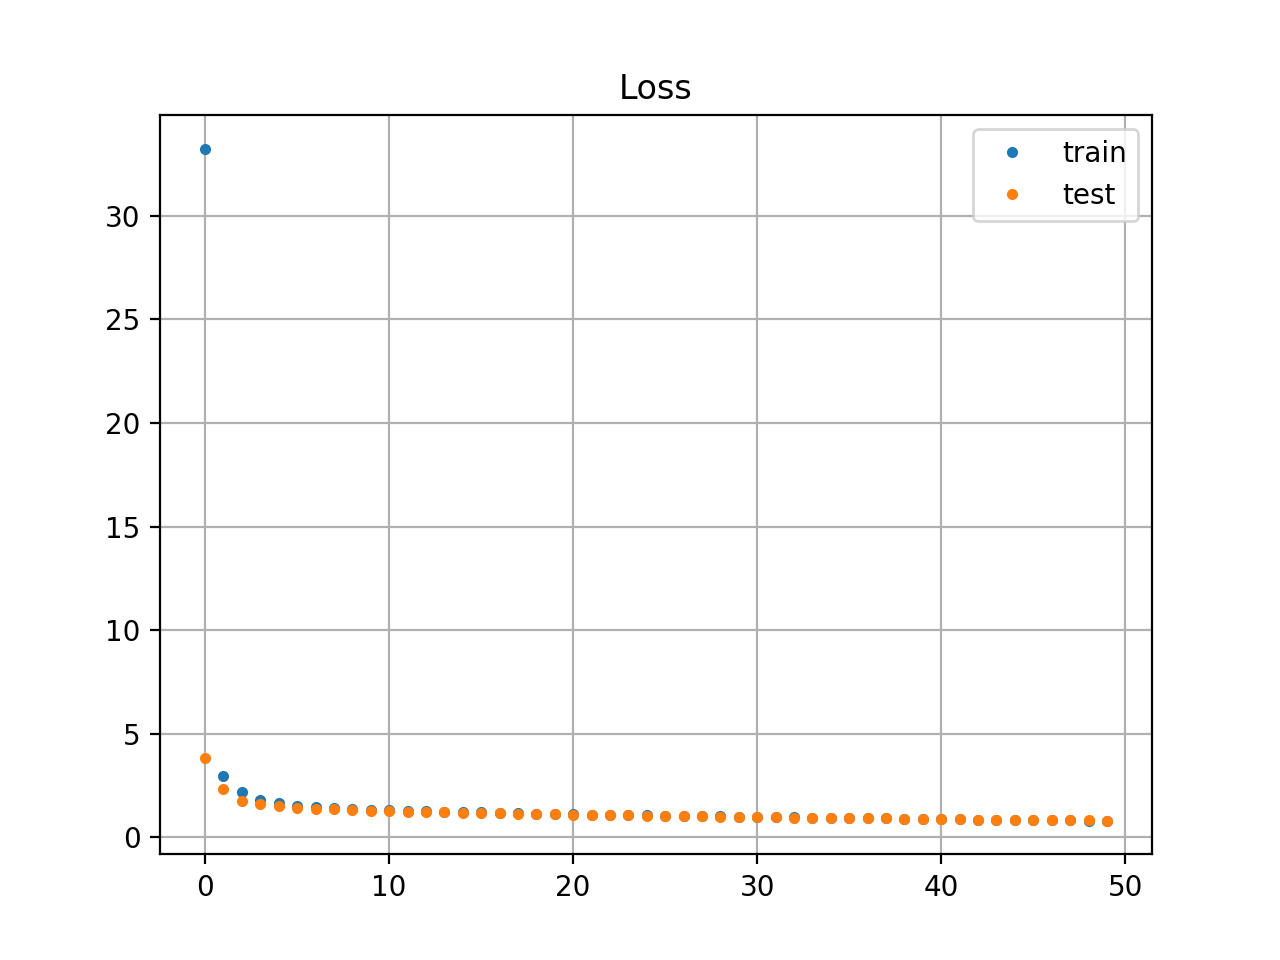

<IPython.core.display.Javascript object>


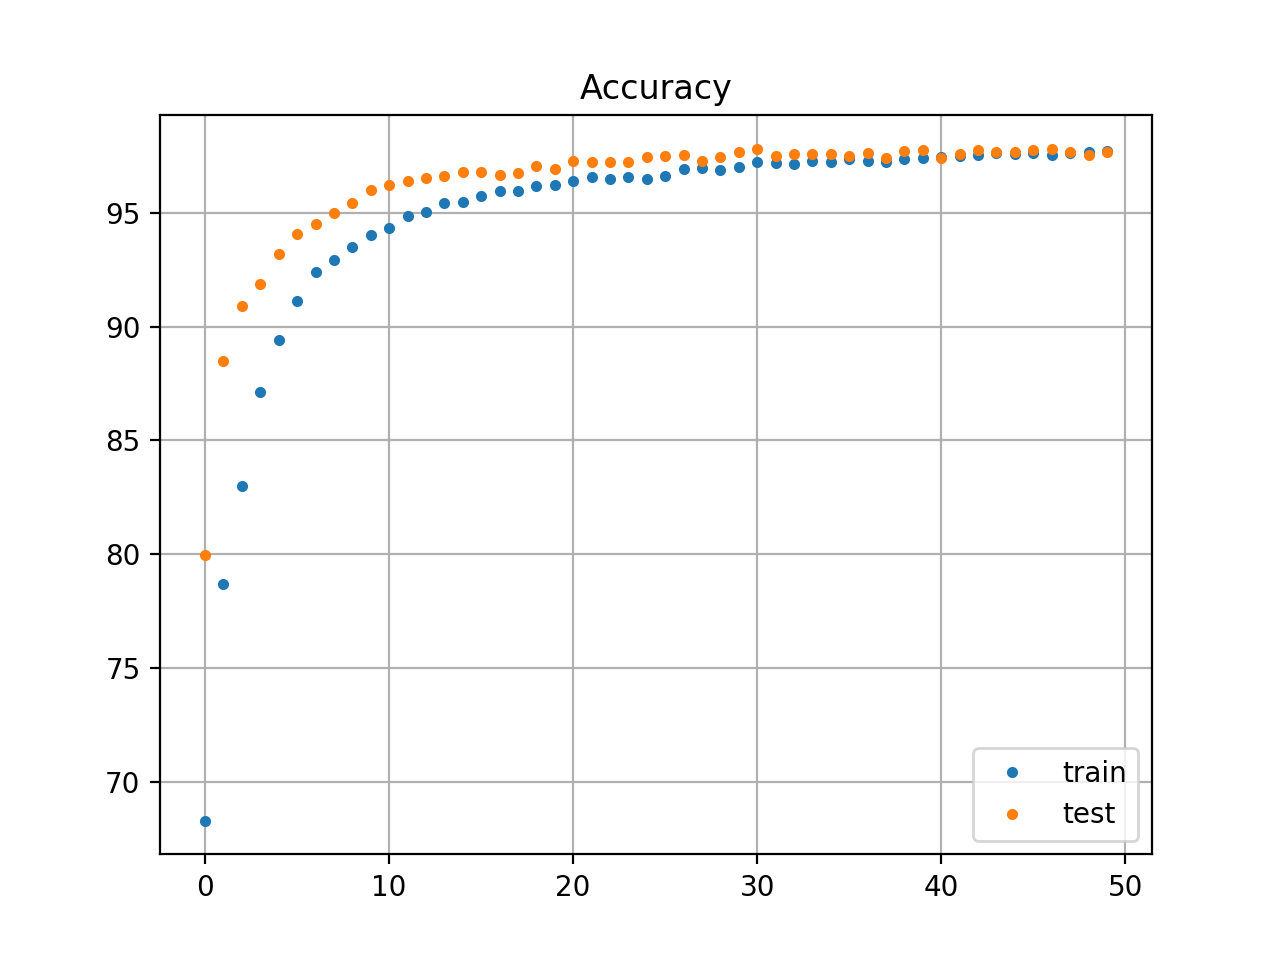

In [21]:
# acc and loss hist
plt.plot(train_res['train_loss_hist'], marker='.', linestyle=' ', label='train')
plt.plot(train_res['test_loss_hist'], marker='.', linestyle=' ', label='test')
plt.grid()
plt.legend()
plt.title('Loss')
plt.show()

plt.plot(train_res['train_acc_hist'], marker='.', linestyle=' ', label='train')
plt.plot(train_res['test_acc_hist'], marker='.', linestyle=' ', label='test')
plt.grid()
plt.legend()
plt.title('Accuracy')
plt.show()

In [22]:
### plot some FGN param movement during training

<IPython.core.display.Javascript object>


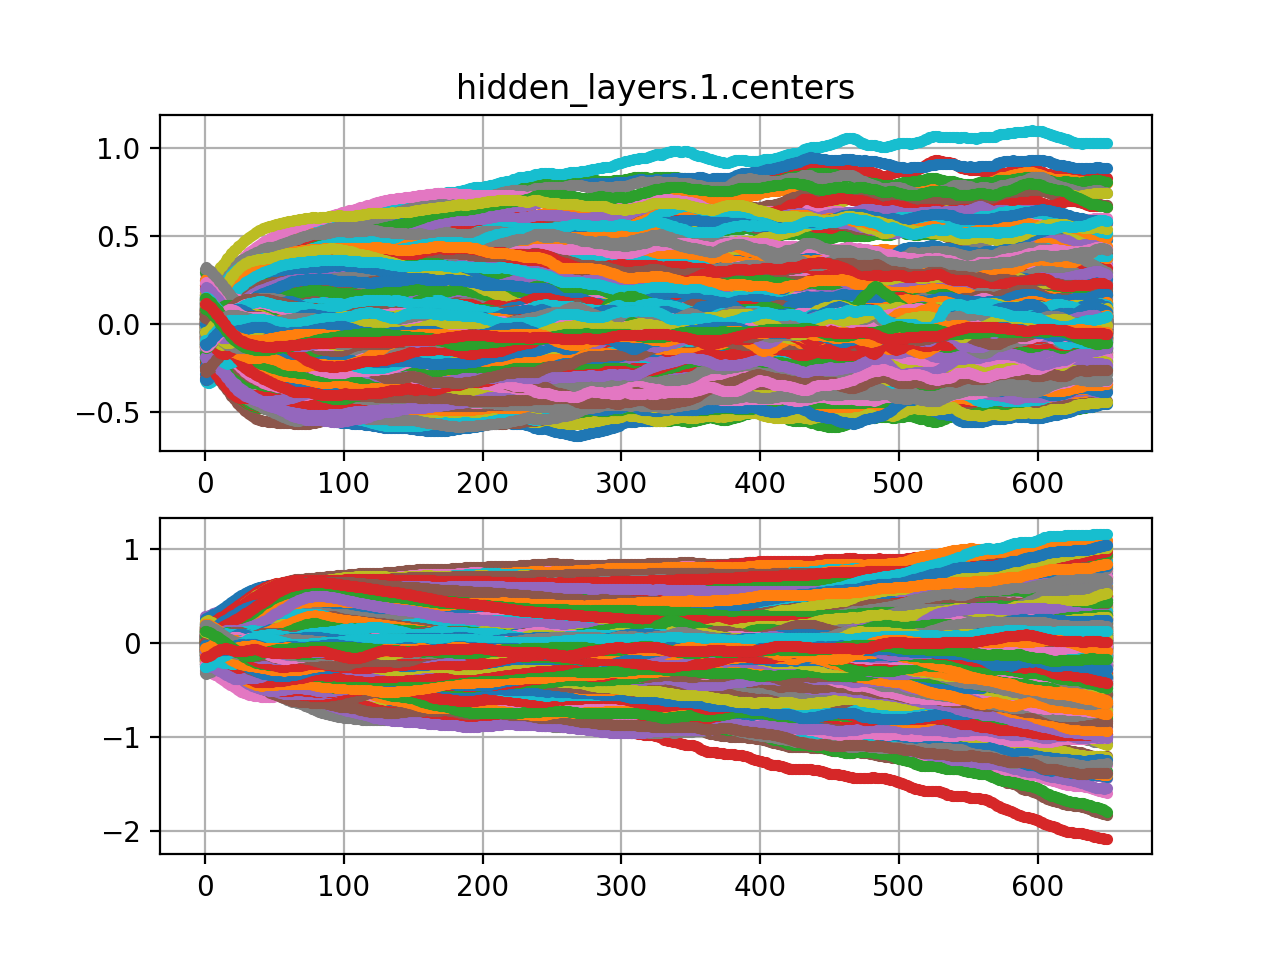

<IPython.core.display.Javascript object>


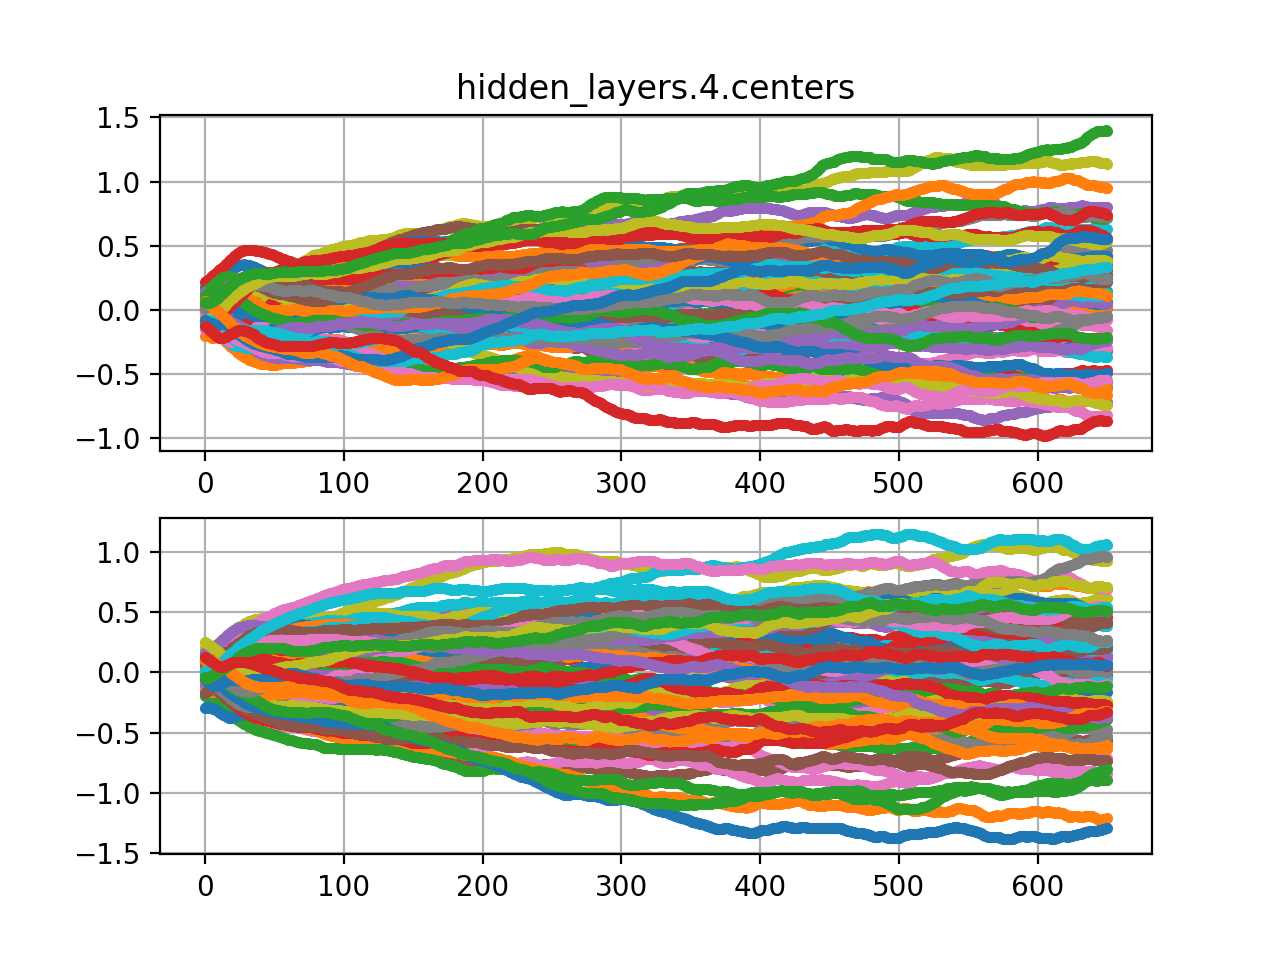

<IPython.core.display.Javascript object>


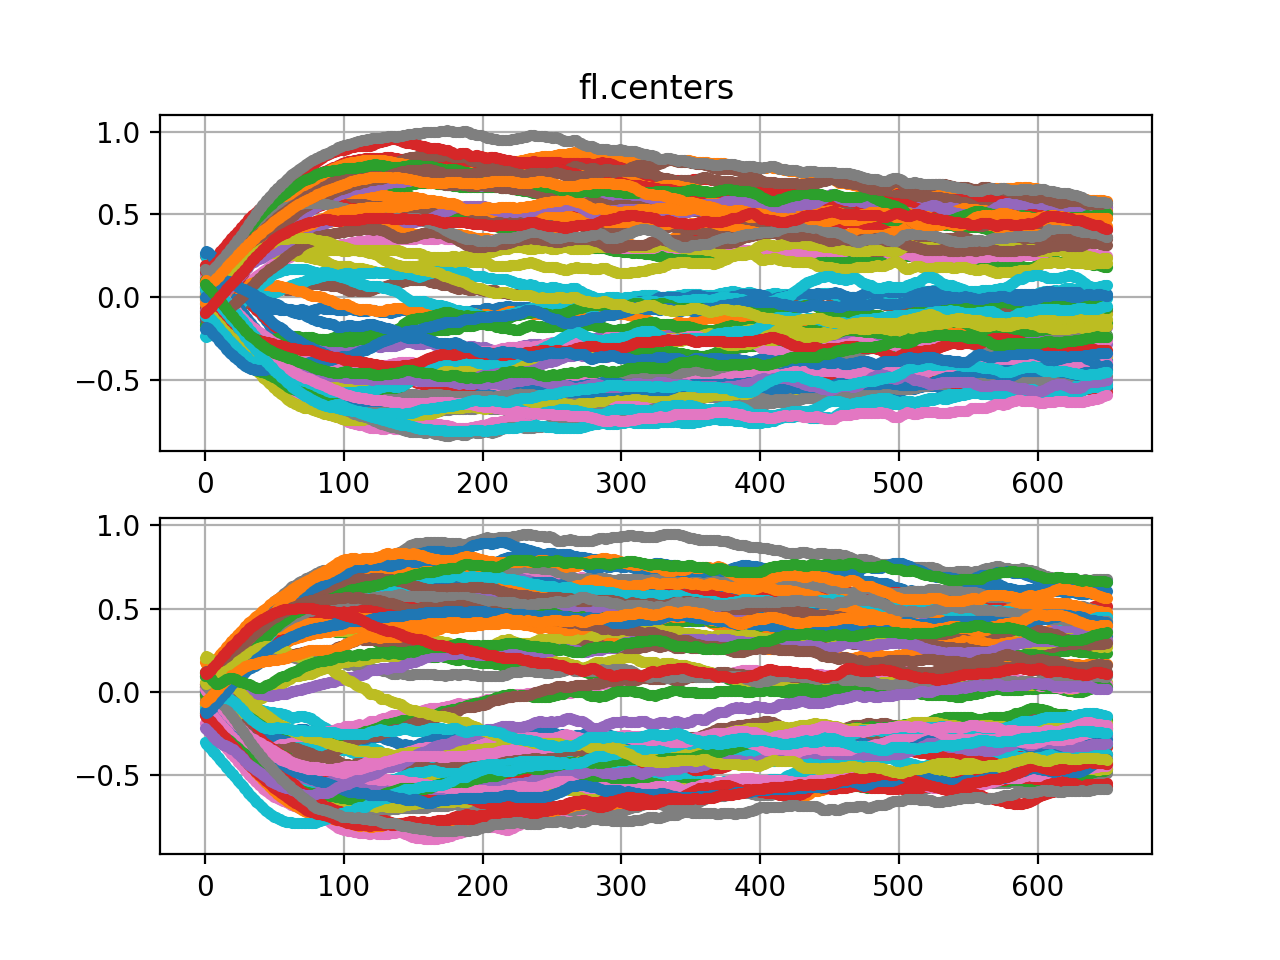

In [23]:
# plot centers history for only some hidden layer neuron
if model_type=='FGN':
    fgnl.plot_centers_histories(train_res['histories'])

<IPython.core.display.Javascript object>


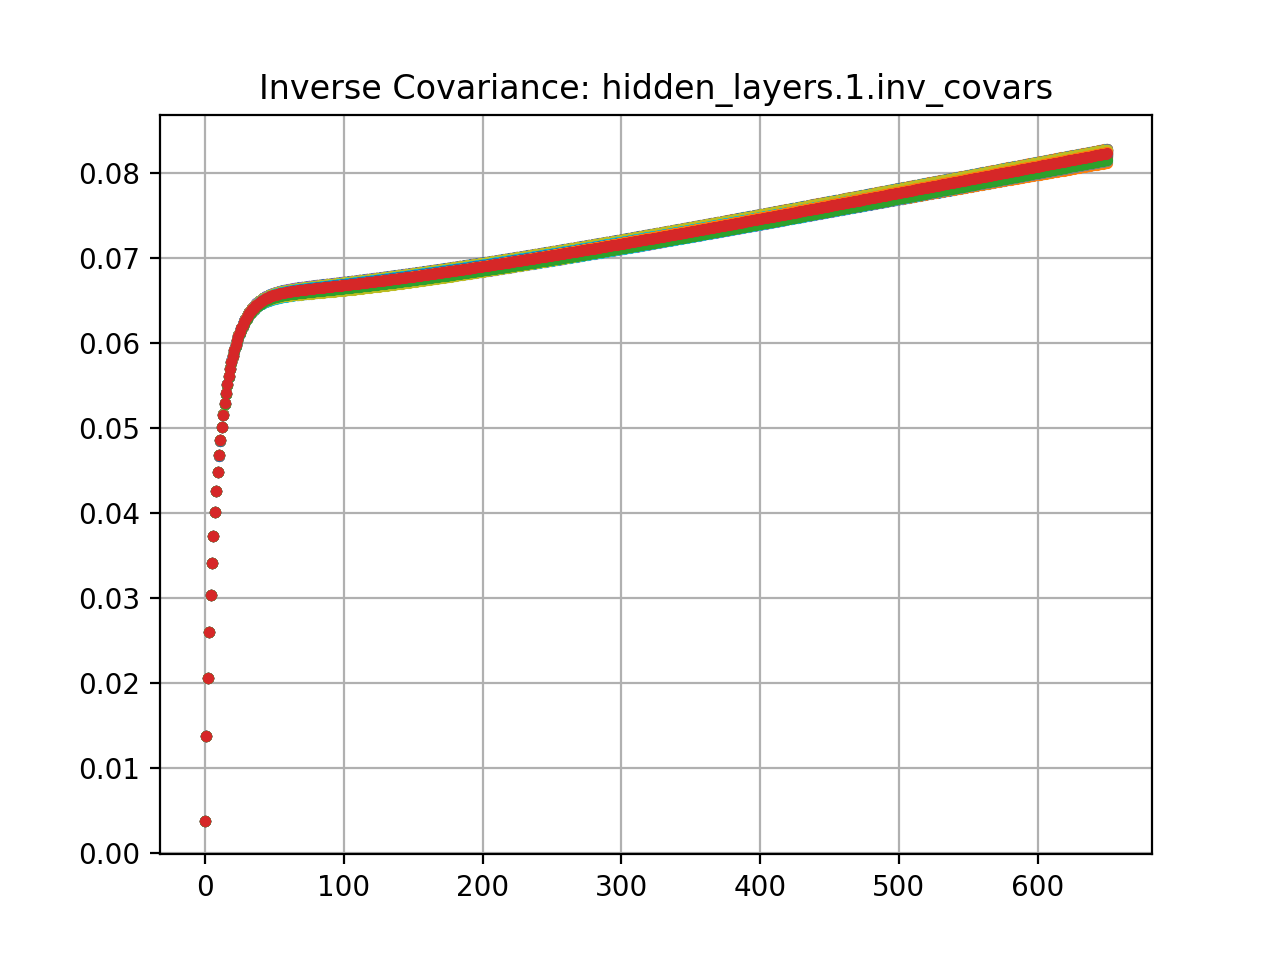

<IPython.core.display.Javascript object>


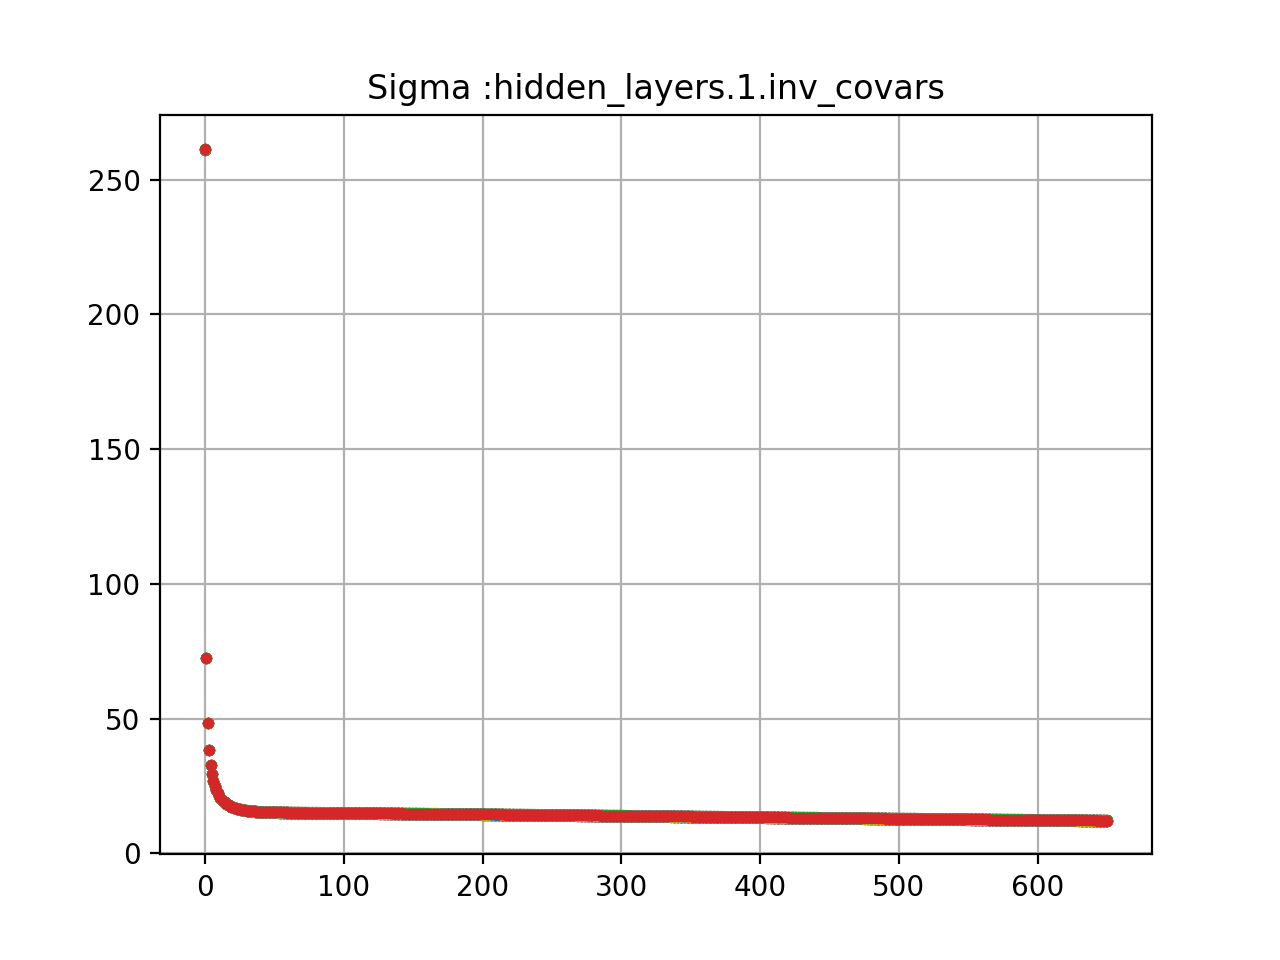

<IPython.core.display.Javascript object>


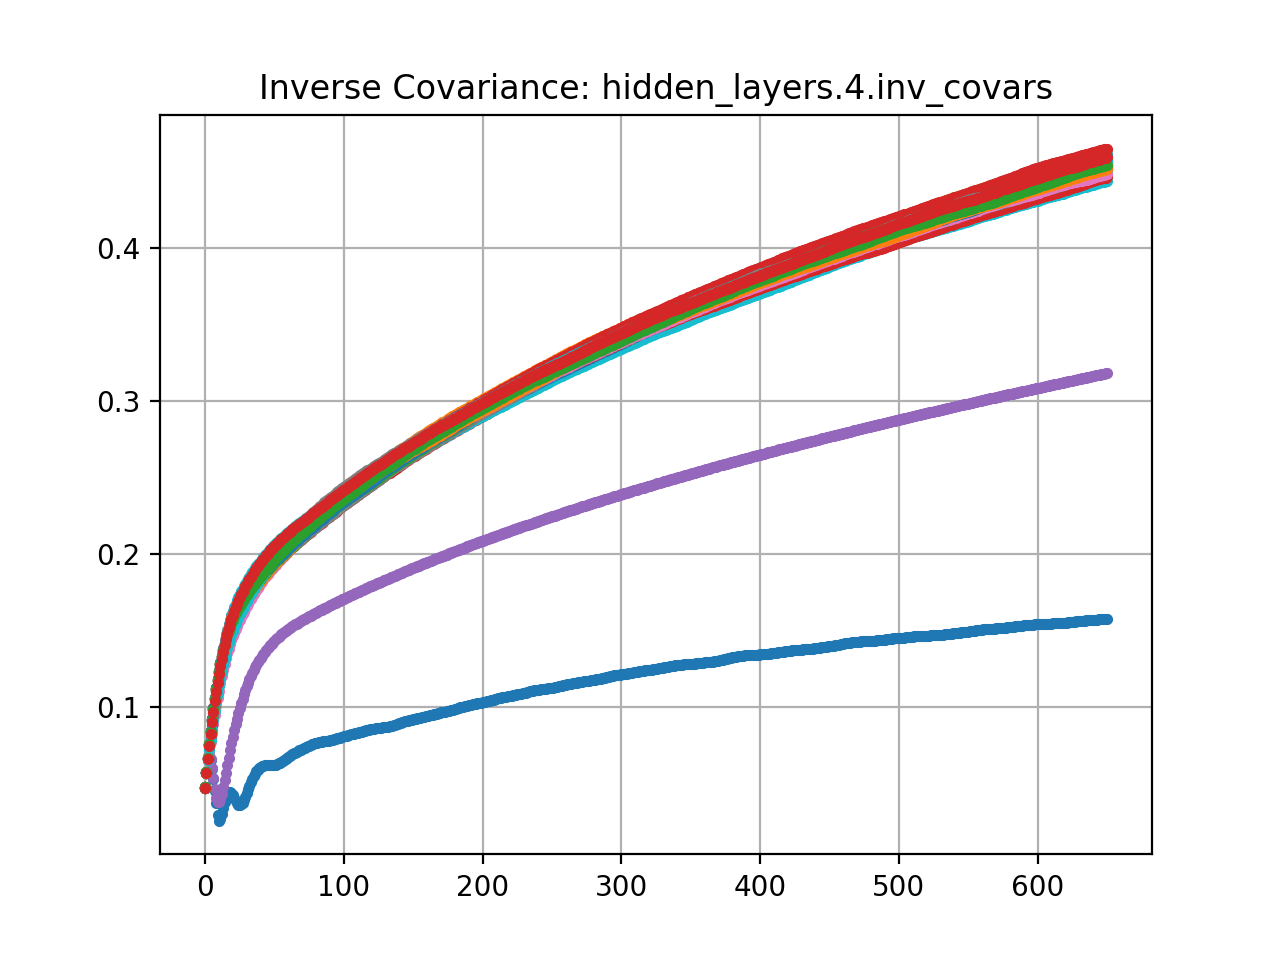

<IPython.core.display.Javascript object>


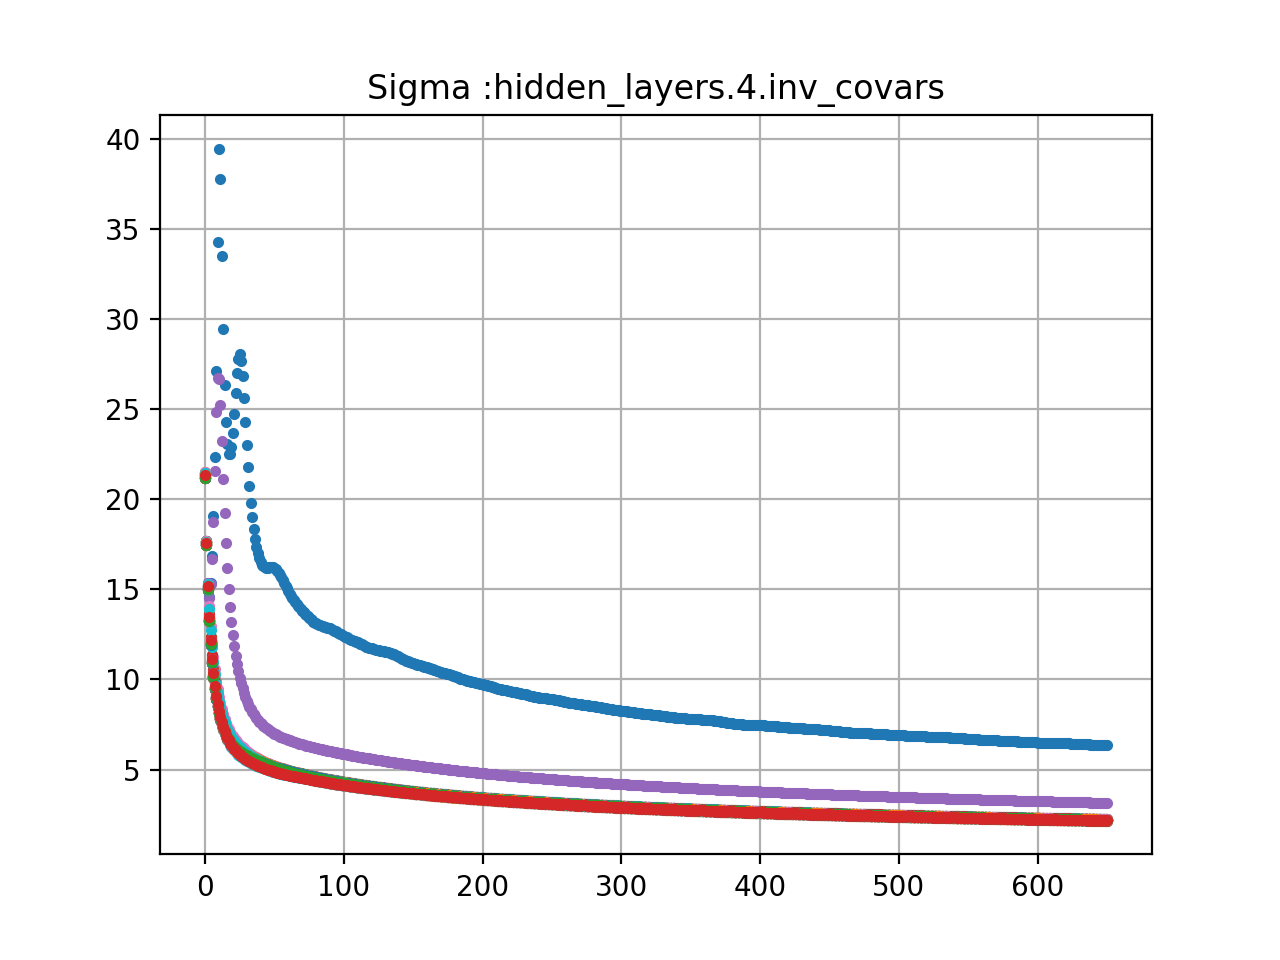

<IPython.core.display.Javascript object>


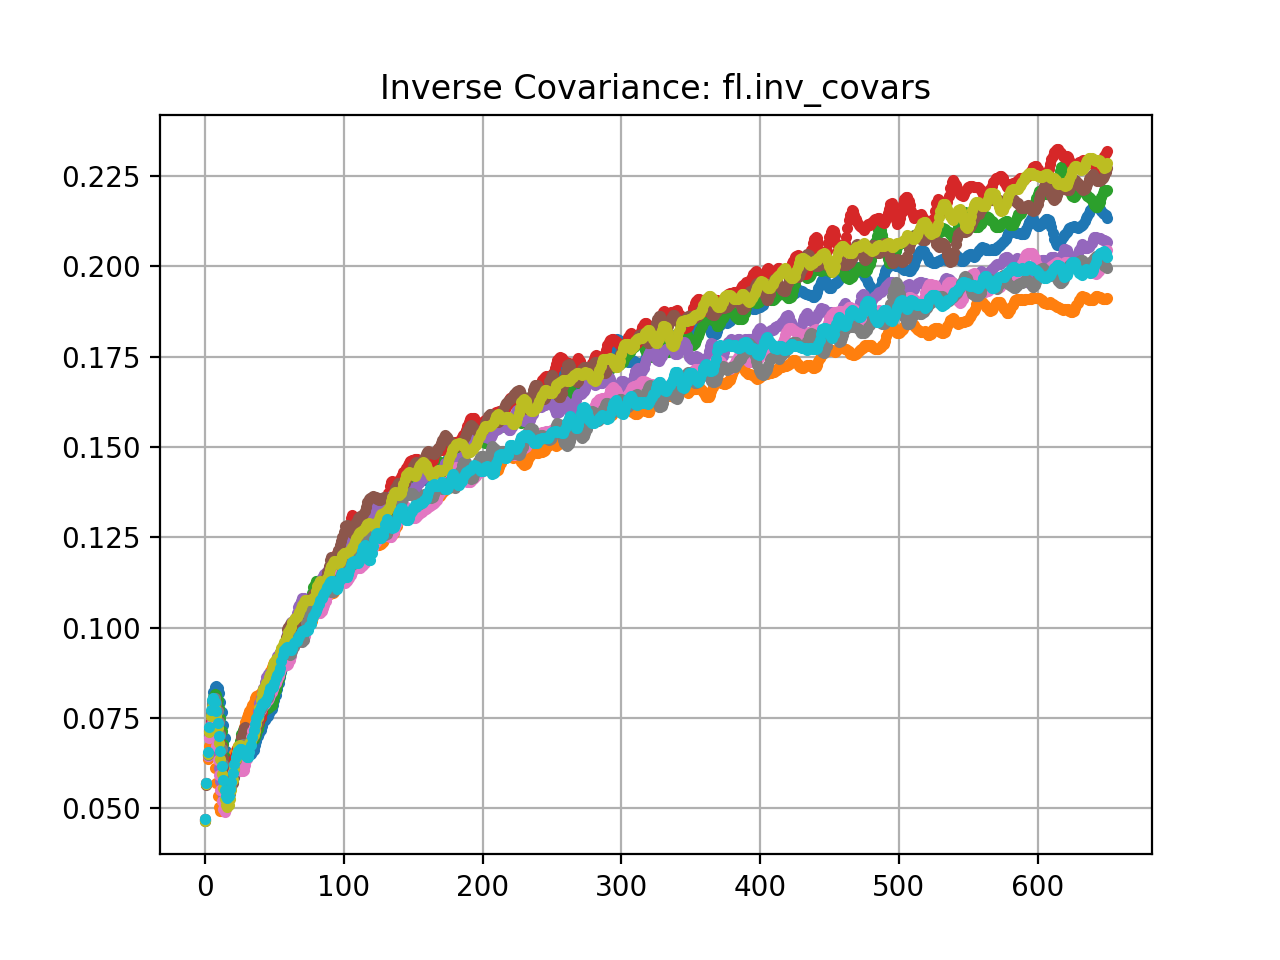

<IPython.core.display.Javascript object>


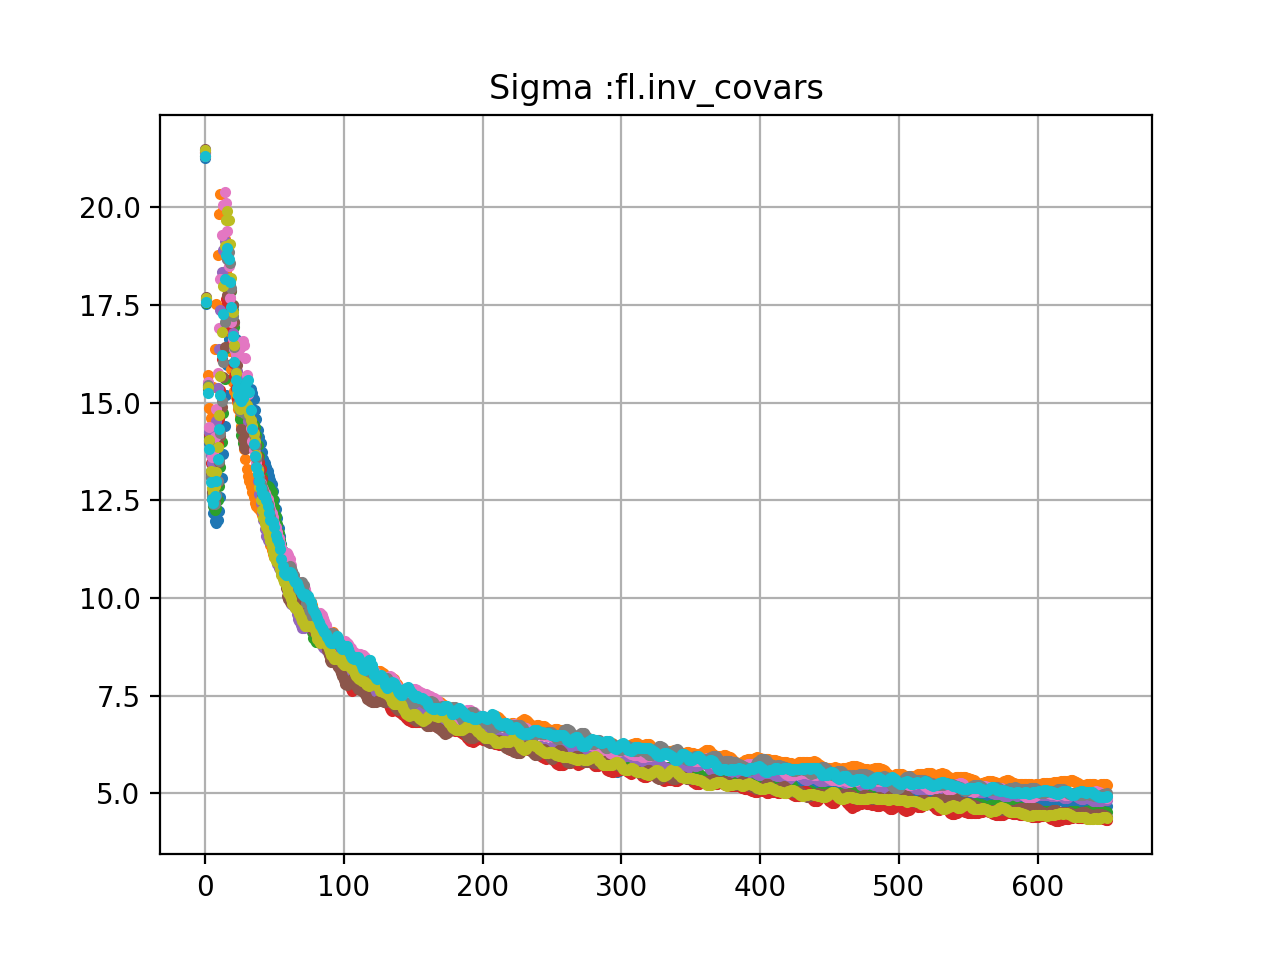

In [24]:
# check that inv covar has gone up, sigmas down, and trace down if covar_type=='full'
if model_type=='FGN':
    fgnl.plot_sigmas_histories(train_res['histories'], covar_type=model.covar_type)

In [25]:
### PART 2: evaluate over random noise

In [26]:
# # load new model if desired
# model_path = '../Experiments/sample_models/sample_classic_full.pth'
# model = torch.load(model_path)
# model.to(device)

In [27]:
# rand_dataloader = fgnh.mnist_random_shuffled_dataloader(num_samples=10000, batch_size=10000)
rand_dataloader = fgnh.mnist_random_dataloader(num_samples=10000, batch_size=10000)

Shape: torch.Size([10000, 28, 28])
torch.Size([28, 28])


<IPython.core.display.Javascript object>


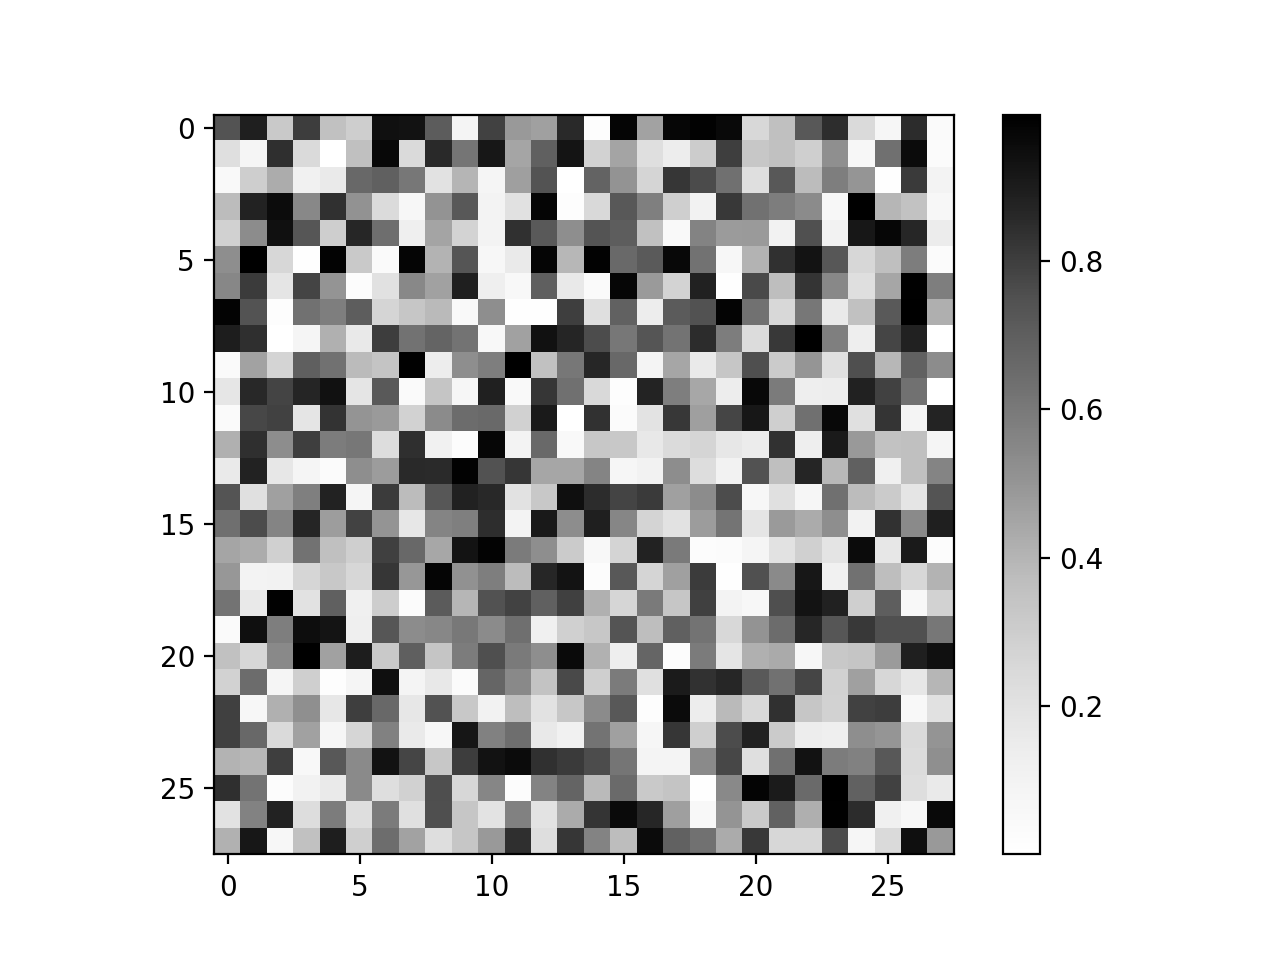

In [28]:
# show an example
print("Shape:", rand_dataloader.dataset.tensors[0].shape)
x = rand_dataloader.dataset.tensors[0][0]
print(x.shape)
# print("sample:", x)

plt.imshow(x, cmap=plt.cm.get_cmap('Greys'))
plt.colorbar()
plt.show()

In [29]:
# set model to eval mode
model.eval()

Feedforward_FGN_net(
  (hidden_layers): ModuleList(
    (0): Dropout(p=0.2, inplace=False)
    (1): FGN_layer()
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): FGN_layer()
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.2, inplace=False)
  )
  (ib): BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fl): FGN_layer()
)

In [30]:
# print first 5 pred
for x_rand in rand_dataloader:
    break
x_rand = x_rand[0]

# apply model to random data
preds = model(x_rand.to(device))
preds = preds.cpu().detach().numpy()
# apply softmax for probs
preds_softmax = np.array([np.exp(x)/sum(np.exp(x)) for x in preds.astype('float128')])

print(np.round(preds_softmax[:5],decimals=2))
print("shape:", preds.shape)

[[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]]
shape: (10000, 10)


In [31]:
# # print first 5 pred in random eval
# try:
#     model.set_random_eval(True)
# except:
#     pass

# # apply model to random data
# preds = model(x_rand.to(device))
# preds = preds.cpu().detach().numpy()
# # apply softmax for probs
# preds_softmax = np.array([np.exp(x)/sum(np.exp(x)) for x in preds.astype('float128')])

# print(np.round(preds_softmax[:5],decimals=2))
# print("shape:", preds.shape)

In [32]:
# #check both eval mode and random eval
# print(model.training)
# for l in model.hidden_layers:
#     if isinstance(l, fgnl.FGN_layer):
#         print(l.random_eval)
#         break

<IPython.core.display.Javascript object>


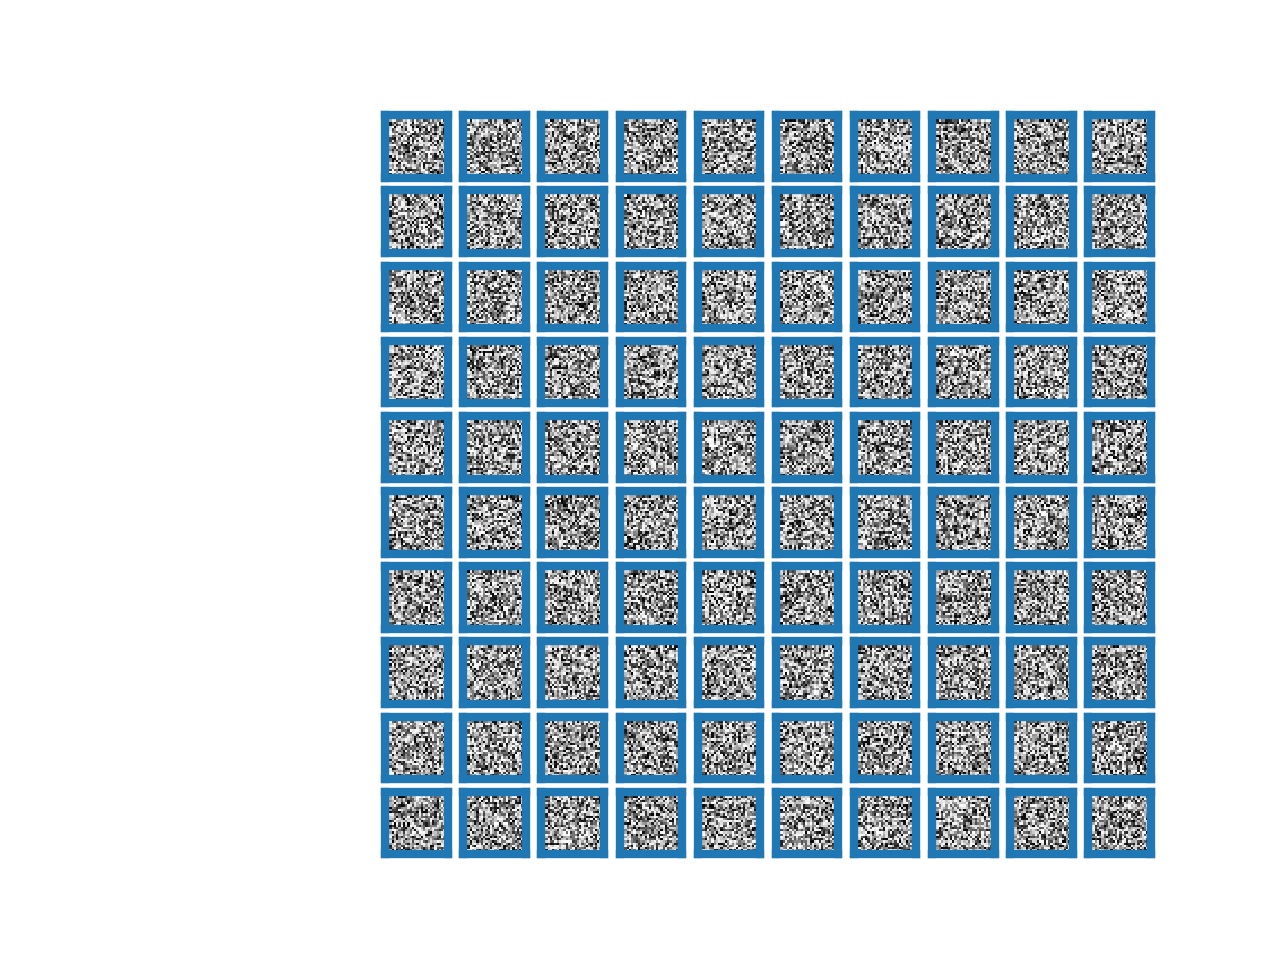

In [33]:
# plot
fig, axes = plt.subplots(nrows=10, ncols=10)
for r in range(10):
    for c in range(10):
        
        x = rand_dataloader.dataset[10*r+c][0].numpy().reshape((28,28))
        
        # is the max bigger than rest combined?
        if np.max(preds_softmax[10*r+c])>=0.5:
            axes[r,c].spines['bottom'].set_color('tab:red')
            axes[r,c].spines['top'].set_color('tab:red')
            axes[r,c].spines['left'].set_color('tab:red')
            axes[r,c].spines['right'].set_color('tab:red')
        
        # is the max close to the min?
        if np.max(preds_softmax[10*r+c])<=0.2:            
            axes[r,c].spines['bottom'].set_color('tab:blue')
            axes[r,c].spines['top'].set_color('tab:blue')
            axes[r,c].spines['left'].set_color('tab:blue')
            axes[r,c].spines['right'].set_color('tab:blue')
            
        axes[r,c].spines['bottom'].set_linewidth(3)
        axes[r,c].spines['top'].set_linewidth(3)
        axes[r,c].spines['left'].set_linewidth(3)
        axes[r,c].spines['right'].set_linewidth(3)
        axes[r,c].tick_params(axis='both', which='both',
                              labelbottom='off', labelleft='off', bottom='off', left='off')
        axes[r,c].xaxis.set_visible(False)
        axes[r,c].yaxis.set_visible(False)

        
        axes[r,c].imshow(x, cmap=plt.cm.get_cmap('Greys'))
#         axes[r,c].axis('off')
plt.subplots_adjust(left=0.3, hspace=0.2)
plt.show()

In [34]:
# quick description of the maxes
preds_maxes = np.max(preds_softmax, axis=1)
print(stats.describe(preds_maxes))
# % of maxes above 0.5
print("percentage of confident predictions (>=0.5):",float(len([x for x in preds_maxes if x>=0.5])/float(len(preds_maxes))))

DescribeResult(nobs=10000, minmax=(0.1, 0.1), mean=0.10000000000000000001, variance=4.5922340313026908473e-41, skewness=-1.0, kurtosis=-2.0)
percentage of confident predictions (>=0.5): 0.0


<IPython.core.display.Javascript object>


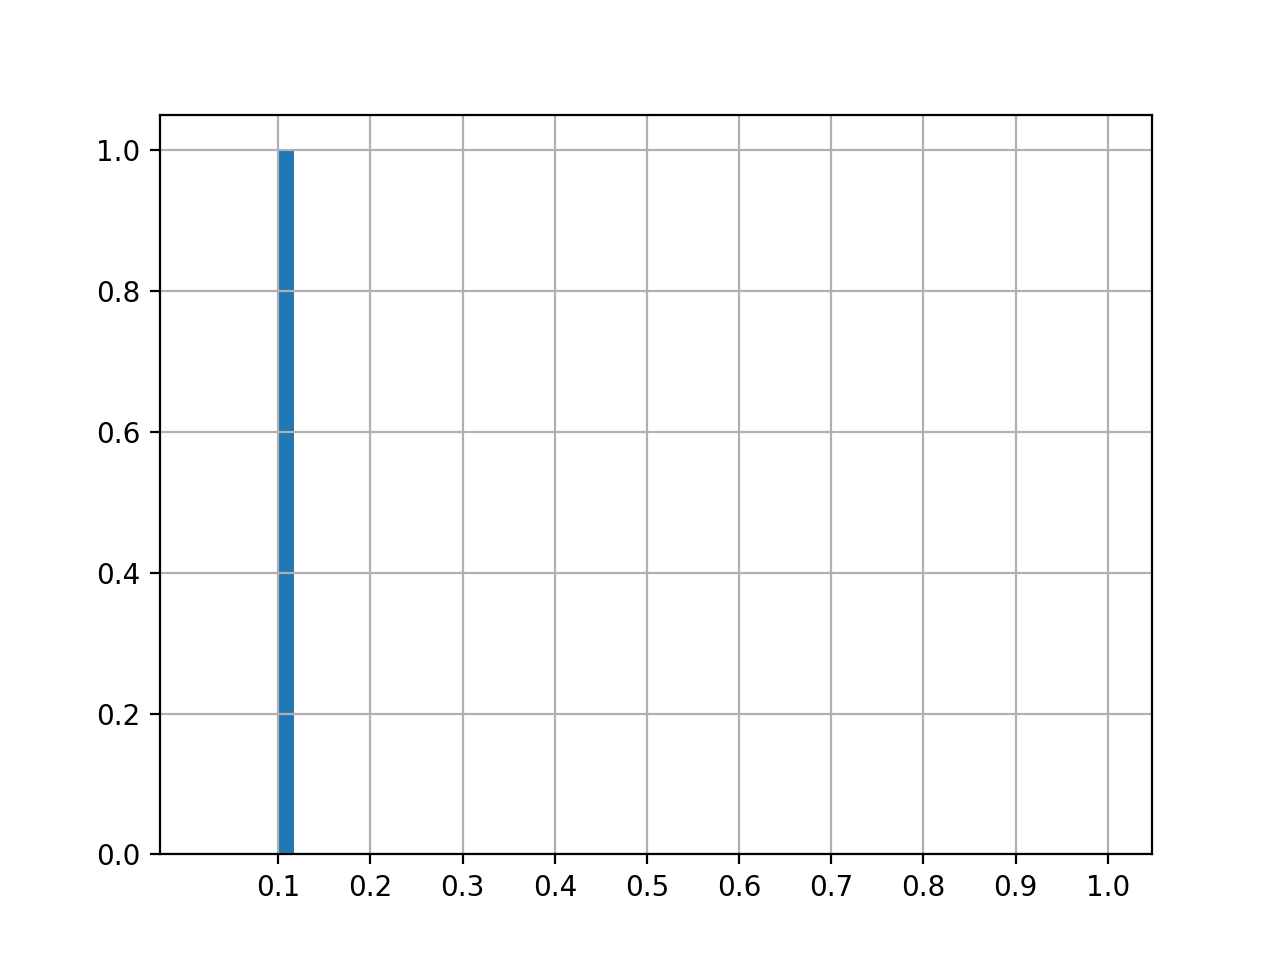

In [35]:
# histogram
weights = np.ones_like(preds_maxes)/len(preds_maxes)
plt.hist(preds_maxes, bins=(np.arange(51)+1)/51.0, rwidth=0.9, align='mid', weights=weights)
plt.xticks((np.arange(10)+1)/10.0)
plt.grid(True)
plt.show()

In [36]:
# histogram over MNIST val data data

for x_mnist in mnist_val_loader:
    break
x_mnist = x_mnist[0]

preds_mnist = model(x_mnist.to(device))
preds_mnist = preds_mnist.cpu().detach().numpy()
# apply softmax for probs
preds_mnist_softmax = np.array([np.exp(x)/sum(np.exp(x)) for x in preds_mnist.astype('float128')])

In [37]:
# quick description of the maxes
preds_maxes = np.max(preds_mnist_softmax, axis=1)
print(stats.describe(preds_maxes))
# % of maxes above 0.5
print("percentage of confident predictions:",float(len([x for x in preds_maxes if x>=0.5])/float(len(preds_maxes))))

DescribeResult(nobs=10000, minmax=(0.1, 0.9999998053047142472), mean=0.98786640964077046724, variance=0.004706642280639772175, skewness=-7.8479378796082184004, kurtosis=72.545933172879512686)
percentage of confident predictions: 0.9948


<IPython.core.display.Javascript object>


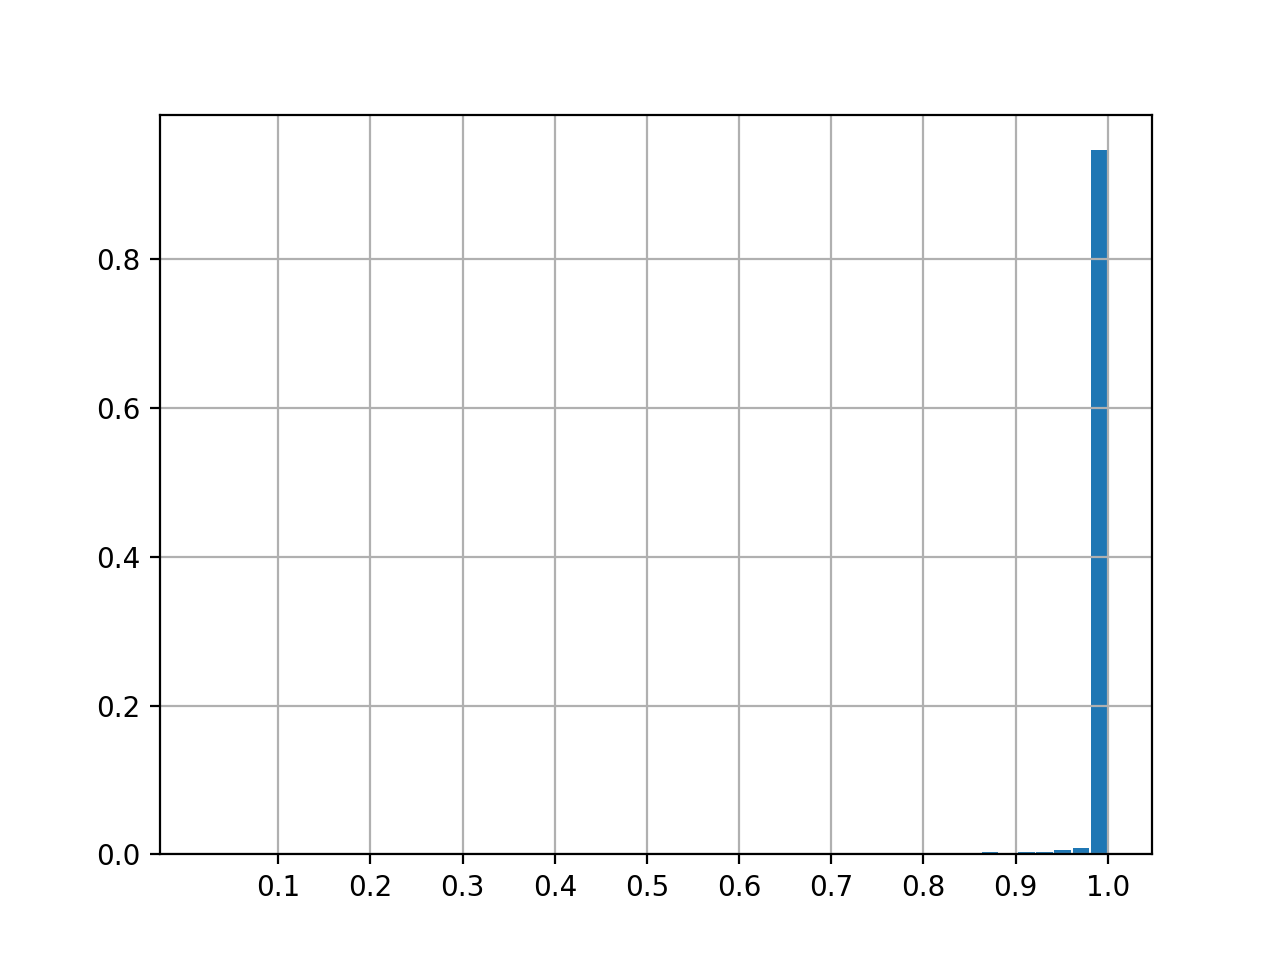

In [38]:
# histogram
weights = np.ones_like(preds_maxes)/len(preds_maxes)
plt.hist(preds_maxes, bins=(np.arange(51)+1)/51.0, rwidth=0.9, align='mid', weights=weights)
plt.xticks((np.arange(10)+1)/10.0)
plt.grid(True)
plt.show()

In [39]:
# save the models as dev models for future use

In [40]:
# model_name = 'sample_{}'.format(model_type)
# save_path = '../Experiments/sample_models/'
# print('Saving trained model {} in {}'.format(model_name, save_path))

# # save model entirely
# torch.save(model, save_path+model_name+'_full.pth')

# # save model weights
# torch.save(model.state_dict(), save_path+model_name+'_state_dict.pth')

# # save training performance
# with open(save_path+model_name+'_history.txt', 'w') as text_file:
#     text_file.write('Train Losses \n{}\n'.format(str(train_res['train_loss_hist'])))
#     text_file.write('Train Acc \n{}\n'.format(str(train_res['train_acc_hist'])))
#     text_file.write('Test Losses \n{}\n'.format(str(train_res['test_loss_hist'])))
#     text_file.write('Test Acc \n{}\n'.format(str(train_res['test_acc_hist'])))

# # save parameters
# with open(save_path+model_name+'_parameters.txt', 'w') as text_file:
#     text_file.write('hidden_layer_sizes {}\n'.format(str(hidden_layer_sizes)))
#     text_file.write('drop_p {}\n'.format(str(drop_p)))
#     text_file.write('batch_size {}\n'.format(str(batch_size)))
#     text_file.write('lambda for l2 loss {}\n'.format(str(lmbda_l2)))
#     text_file.write('optimizer {}\n'.format(str(optimizer)))
#     if model_type=='FGN':
#         text_file.write('ordinal {}\n'.format(str(ordinal)))
#         text_file.write('covar_type {}\n'.format(str(covar_type)))
#         text_file.write('lambda for sigma loss {}\n'.format(str(lmbda_sigs)))
#         text_file.write('non-linearity {}\n'.format(str(non_lin)))
